<a href="https://colab.research.google.com/github/ArminD93/Intel-Image-Classification/blob/dev/Intel_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intel Image Classification**
---

# **Spis treści:**

# 1. [**Import bibliotek**](#0)
# 2. [**Przygotowanie danych:**](#1)
  ## 2.1. [Liczba zdjęć dla poszczególnych klas](#2)
  ## 2.2. [Utworzenie katalogów train, test, valid](#3)
  ## 2.3. [Określenie rozmiaru danych](#4)  
  ## 2.4. [Przekopiowanie danych do wybranych folderów](#5)
  ## 2.5. [Prezentacja danych](#6)
  ## 2.6. [Augmentacja danych](#7)
# 3. [**Sieci neuronowe:**](#8)  
  ## 3.1. [Budowa modeli](#9)
   ### 3.1.1. [MODEL 1](#10)
   ### 3.1.2. [MODEL 2](#11)
   ### 3.1.3. [MODEL 3](#12)
   ### 3.1.4. [MODEL 4](#13)
   ### 3.1.5. [MODEL 5](#14)
## 3.2. [Utworzenie obiektów](#15)   
## 3.3. [Trenowanie sieci](#16)
## 3.4. [Zapisanie modeli](#17)
## 3.5. [Charakterystyki trenowanych modeli](#18)
## 3.6. [Testowanie modeli](#19)
   ### 3.6.1. [Najlepsze modele](#20)
   ### 3.6.2. [Wyświetlenie błędnie sklasyfikowanych zdjęć](#21)
# 4. [**Testowanie PyTorch'a:**](#22)  

# <a name='0'></a> **1. Import bibliotek**




In [1]:
import os
import time
from datetime import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil # Pomaga w kopiowaniu plików
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, concatenate, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

np.set_printoptions(precision=12, suppress=True)

In [ ]:
%load_ext tensorboard

# <a name='1'></a> **2. Przygotowanie danych**

In [2]:
 !unzip -q "/content/drive/My Drive/ColabNotebooks/intel_image/data/intel_image.zip" 

## <a name='2'></a>2.1. Liczba zdjęć dla poszczególnych klas

In [3]:
!rm -rf ./images

base_dir = './intel_image' # Przypisujemy katalog bazowy

raw_no_of_files = {}

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
for dir in classes: 
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('buildings', 2628), ('forest', 2745), ('glacier', 2957), ('mountain', 3037), ('sea', 2784), ('street', 2883)])

## <a name='3'></a>2.2. Utworzenie katalogów train, test, valid

In [4]:
data_dir = './images' # Przypisujemy katalog bazowy

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog dla zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog dla zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog dla  zbioru testowego

# Wskażemy klasy
train_buildings_dir = os.path.join(train_dir, 'buildings')
train_forest_dir = os.path.join(train_dir, 'forest')
train_glacier_dir = os.path.join(train_dir, 'glacier')
train_mountain_dir = os.path.join(train_dir, 'mountain')
train_sea_dir = os.path.join(train_dir, 'sea')
train_street_dir = os.path.join(train_dir, 'street')

valid_buildings_dir = os.path.join(valid_dir, 'buildings')
valid_forest_dir = os.path.join(valid_dir,    'forest'  )
valid_glacier_dir = os.path.join(valid_dir, 'glacier')
valid_mountain_dir = os.path.join(valid_dir, 'mountain')
valid_sea_dir = os.path.join(valid_dir, 'sea')
valid_street_dir = os.path.join(valid_dir, 'street')

test_buildings_dir = os.path.join(test_dir, 'buildings')
test_forest_dir = os.path.join(test_dir, 'forest')
test_glacier_dir = os.path.join(test_dir, 'glacier')
test_mountain_dir = os.path.join(test_dir, 'mountain')
test_sea_dir = os.path.join(test_dir, 'sea')
test_street_dir = os.path.join(test_dir, 'street')

# Pętla, która przejdzie po naszych katalogach
for i, directory in enumerate([train_dir, valid_dir, test_dir]):
    if not os.path.exists(directory): # Jeśli takie ścieżki nie istenieją, to po prostu utowrzymy te katalogi
        os.mkdir(directory)

# To samo wykonamy z katalogami w trzecim pozimie
dirs = [train_buildings_dir, train_forest_dir, train_glacier_dir, train_mountain_dir, train_sea_dir, train_street_dir,
        valid_buildings_dir, valid_forest_dir, valid_glacier_dir, valid_mountain_dir, valid_sea_dir, valid_street_dir,
        test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir 
        ]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)       

In [5]:
# Teraz musimy znać pełne ścieżki do naszych plików
base_dir = './intel_image' # Przypisujemy katalog bazowy, gdzie są zdjęcia

# Do zmiennej _fnames przypisujemy wylistowanie katalogu z katalogu bazowego, tam gdzie są zdjęcia
buildings_files_names = os.listdir(os.path.join(base_dir, 'buildings')) 
forest_files_names = os.listdir(os.path.join(base_dir,    'forest'))
glacier_files_names = os.listdir(os.path.join(base_dir,   'glacier'))
mountain_files_names = os.listdir(os.path.join(base_dir,  'mountain'))
sea_files_names = os.listdir(os.path.join(base_dir,       'sea'))
street_files_names = os.listdir(os.path.join(base_dir,    'street'))

test_files_names = os.listdir(os.path.join(base_dir,      'test'))

## <a name='4'></a>2.3. Określenie rozmiaru danych

In [6]:
# W związku z tym, że są różne wartości danych, w różnych klasach,
# Wybierzemy minimalną długość z tych dwóch klas i przypiszemy do zmiennej rozmiar
size = min(len(buildings_files_names), len(forest_files_names), len(glacier_files_names), len(mountain_files_names), len(sea_files_names), len(street_files_names))

train_size = int(np.floor(0.7 * size)) # rozmiar danych treningowych to 70% wszystkich zdjęć                                     
valid_size = int(np.floor(0.28 * size)) 
test_size = size - (train_size + valid_size) # Testowy zbiór to będzie 10%


## <a name='5'></a>2.4. Przekopiowanie danych do wybranych folderów

In [7]:
def filesCopy(directory_dir):

  train_id = train_size
  valid_id = train_size + valid_size
  test_id = train_size + valid_size + test_size

  for i, dictio in enumerate(directory_dir):
    dir_name = [val for val in directory_dir.values() ][i]
    label_name = dictio
    
    for i, fname in enumerate(dir_name[0]):
        if i <= train_id:                                  
            src = os.path.join(base_dir, label_name, fname)   
            dst = os.path.join(dir_name[1], fname)
            shutil.copyfile(src, dst)
        elif train_id < i <= valid_id:
            src = os.path.join(base_dir, label_name, fname)
            dst = os.path.join(dir_name[2], fname)      
            shutil.copyfile(src, dst)
        elif valid_id < i < test_id:
            src = os.path.join(base_dir, label_name, fname)     
            dst = os.path.join(dir_name[3], fname)
            shutil.copyfile(src, dst)

    print(f'{label_name} - zbiór treningowy:  { len(os.listdir(dir_name[1] )) } ')
    print(f'{label_name} - zbiór walidacyjny: { len(os.listdir(dir_name[2] )) } ')
    print(f'{label_name} - zbiór testowy:     { len(os.listdir(dir_name[3] )) } ')
    print()
# ----------------------------------------------------------------------------------------------------

directory_dir = {
                  'buildings' : [buildings_files_names,  train_buildings_dir,  valid_buildings_dir,  test_buildings_dir ],
                  'forest'    : [forest_files_names,     train_forest_dir,     valid_forest_dir,     test_forest_dir    ],
                  'glacier'   : [glacier_files_names,    train_glacier_dir,    valid_glacier_dir,    test_glacier_dir   ],   
                  'mountain'  : [mountain_files_names,   train_mountain_dir,   valid_mountain_dir,   test_mountain_dir  ],   
                  'sea'       : [sea_files_names,        train_sea_dir,        valid_sea_dir,        test_sea_dir       ],   
                  'street'    : [street_files_names,     train_street_dir,     valid_street_dir,     test_street_dir    ]   
                }

filesCopy(directory_dir)  

buildings - zbiór treningowy:  1840 
buildings - zbiór walidacyjny: 735 
buildings - zbiór testowy:     53 

forest - zbiór treningowy:  1840 
forest - zbiór walidacyjny: 735 
forest - zbiór testowy:     53 

glacier - zbiór treningowy:  1840 
glacier - zbiór walidacyjny: 735 
glacier - zbiór testowy:     53 

mountain - zbiór treningowy:  1840 
mountain - zbiór walidacyjny: 735 
mountain - zbiór testowy:     53 

sea - zbiór treningowy:  1840 
sea - zbiór walidacyjny: 735 
sea - zbiór testowy:     53 

street - zbiór treningowy:  1840 
street - zbiór walidacyjny: 735 
street - zbiór testowy:     53 



## <a name='6'></a>2.5. Prezentacja danych

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia ze zbioru treningowego:
buildings_idx = 338 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(buildings_files_names))
img_path = os.path.join(train_buildings_dir, names_mapping[buildings_idx])
img_buildings = image.load_img(img_path)

forest_idx = 1302 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(forest_files_names))
img_path = os.path.join(train_forest_dir, names_mapping[forest_idx])
img_forest = image.load_img(img_path)

glacier_idx = 122 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(glacier_files_names))
img_path = os.path.join(train_glacier_dir, names_mapping[glacier_idx])
img_glacier = image.load_img(img_path)

mountain_idx = 1437 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(mountain_files_names))
img_path = os.path.join(train_mountain_dir, names_mapping[mountain_idx])
img_mountain = image.load_img(img_path)

sea_idx = 980 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(sea_files_names))
img_path = os.path.join(train_sea_dir, names_mapping[sea_idx])
img_sea = image.load_img(img_path)

street_idx = 171 #@param {type:'slider', min:0, max:1839}
names_mapping = dict(enumerate(street_files_names))
img_path = os.path.join(train_street_dir, names_mapping[street_idx])
img_street = image.load_img(img_path)

fig, ax = plt.subplots(2,3,figsize=(23, 15))

ax[0,0].imshow(img_buildings)
ax[0,1].imshow(img_forest)
ax[0,2].imshow(img_glacier)

ax[1,0].imshow(img_mountain)
ax[1,1].imshow(img_sea)
ax[1,2].imshow(img_street)


ax[0,0].axis(False)
ax[0,1].axis(False)
ax[0,2].axis(False)

ax[1,0].axis(False)
ax[1,1].axis(False)
ax[1,2].axis(False)

plt.show()

## <a name='7'></a>2.6. Augmentacja danych

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=10,                                        # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,                                          # przeskalowujemy wszystkie obrazy o współczynnik 1/255
    width_shift_range=0.1,                                    # pionowe przekształcenia obrazu 
    height_shift_range=0.1,                                   # poziome przekształcenia obrazu
    shear_range=0.2,                                          # zares losowego przycianania obrazu
    zoom_range=0.1,                                           # zakres losowego przybliżania obrazu
    horizontal_flip=True,                                     # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'                                       # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

valid_datagen = ImageDataGenerator(rescale=1./255.) 


# Budujemy generatory
train_generator = train_datagen.flow_from_directory(directory=train_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')  # batch size 32
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')                                           

Found 11040 images belonging to 6 classes.
Found 4410 images belonging to 6 classes.


In [ ]:
def display_augmented_images(directory, index):

    files_names = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = files_names[index]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    
    plt.figure(figsize=(23, 10))

    image_no = 1
    for batch in train_datagen.flow(x, batch_size=1):
        if image_no == 16:
            break      
        plt.subplot(3, 5, image_no)
        plt.axis(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        image_no += 1


In [ ]:
buildings_index = 311 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_buildings_dir, buildings_index)

#@title Zbiór treningowy forest:
forest_index = 458 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_forest_dir, forest_index)

glacier_index = 174 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_glacier_dir, glacier_index)

mountain_index = 77 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_mountain_dir, mountain_index)

sea_index = 839 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_sea_dir, sea_index)

street_index = 635 #@param {type:'slider', min:0, max:1839}  
display_augmented_images(train_street_dir, street_index)

# <a name='8'></a> **3. Sieci neuronowe**

In [9]:
class Network:
  
  def __init__(self, model_name, epochs, optimizer):
      self.model_name = model_name
      self.epochs = epochs
      self.optimizer = optimizer
      self.tz = 'CEST'

  def model_summary(self):
      self.model_name.summary()

  def save_model(self, file_name):
      self.models_dir = '/content/drive/My Drive/ColabNotebooks/intel_image/models/' + dt.now().strftime('%Y-%m-%d/')
      if not os.path.exists(self.models_dir):
        os.makedirs(self.models_dir)
      self.model_name.save(self.models_dir + file_name + '.h5')

  def train(self, verbose=0, ):

      self.model_name.compile(optimizer= self.optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
       
      log_dir = 'logs/' + dt.now().strftime('%Y-%m-%d_%H:%M:%S'+ self.tz) 
      tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1 )
      # --------------------------------------------------------
      time_start = time.time()
      self.history = self.model_name.fit( train_generator, steps_per_epoch= steps_per_epoch, epochs= self.epochs,
                          validation_data= valid_generator, validation_steps= validation_steps,
                          verbose= verbose, callbacks= [tensorboard, checkpoint]
                          )
      time_stop = time.time()
      print()
      print('Czas trenowania sieci: {} sek'.format(time_stop - time_start))
      # --------------------------------------------------------
      self.scores = self.model_name.evaluate(valid_generator, steps=validation_steps, verbose=0)
      print('Loss: {:.4f}'.format(self.scores[0]) )
      print('Accuracy: {:.4f}'.format(self.scores[1]) )

  def plot_hist(self, title):
      self.metric = 'accuracy'
      self.val_metric = 'val_accuracy'
      self.score = self.scores[1]

      sns.set_style("darkgrid")
      fig, axes = plt.subplots(1,2, figsize=(27,5))
      fig.suptitle(title)

      for self.i in range(2):
        if self.i == 1:
           self.metric = 'loss'
           self.val_metric = 'val_loss'
           self.score = self.scores[0]
        axes[self.i].plot(self.history.history[ self.val_metric], label= self.val_metric)
        axes[self.i].plot(self.history.history[ self.metric], label=  self.metric)
        axes[self.i].set(xlabel='epoki', ylabel= self.metric, title= self.metric+f': {self.score:.4f}')  
        axes[self.i].legend(loc='best')
      plt.show()

In [10]:
!rm -rf ./logs

path ='/content/drive/My Drive/ColabNotebooks/intel_image/model/kopia/best_model.hdf5' 

checkpoint = ModelCheckpoint(filepath=path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=80)

batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

## <a name='9'></a>3.1. Budowa modeli

In [11]:
def Conv2D_block(y, number_of_layers, filters, kernel_size):

  for i in range(number_of_layers):
    y = Conv2D(filters= filters, kernel_size= kernel_size, activation='relu', padding='same')(y)
    y = BatchNormalization()(y)
  return y

### <a name='10'></a>3.1.1. MODEL 1

In [12]:
# ------------------------MODEL 1-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters=32, kernel_size=7) 
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 2, filters=32, kernel_size=3) # 6.10 n_l=1 L0.66A0.75 | 8.11 nl=2 L0.58A0.78
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters=32, kernel_size=3) # 21.10 nl=1 L0.61A0.79 | 22.10 nl=2 L0.59A0.78 | 24.10 nl=1 L0.57A0.78 | 10.11 nl=2 L0.57A80 | 15.11 nl=3 L0.62A0.78 | 17.11 nl=5 L0.77A0.70 | 20.11 nl=3 L0.53A0.81

y = Conv2D_block(y, number_of_layers= 3, filters=64, kernel_size=3) # 22.10 nl=3 L0.59A0.78 | 23.10 nl=5 L0.60A0.78  | 27.10 nl=2 L0.52A0.80 | 13.11 f=32 L0.58A0.79 | 14.11 f=32, nl=3 L0.58A0.79 | 16.11 nl=5 L0.68A0.73 | 21.10 nl=3 L0.61A0.78


y = Conv2D_block(y, number_of_layers= 2, filters=64, kernel_size=3) # 29.10  nl=2 L0.55A0.80 | 30.10 nl=5 L0.63A0.76 | 1.11  nl=2 L0.58A0.78 | 3.11 nl=1 L0.54A0.78
y = MaxPooling2D(pool_size=2)(y)                                  # 31.10 L0.71A0.71 | 2.11 ## L0.60A0.77 | 18.11 ## L0.66A0.75 |19.11 L0.68A0.75 | 22.11 nl=2

y = Conv2D_block(y, number_of_layers= 1, filters=64, kernel_size=1) 
y = Conv2D_block(y, number_of_layers= 1, filters=64, kernel_size=3)
y = Conv2D_block(y, number_of_layers= 1, filters=128, kernel_size=1)
# y = MaxPooling2D(pool_size=2)(y)                                  # 6.11 ## L0.54A0.78 | 7.11 L0.50A0.82 | 18.11 L0.66A0.75 | 19.11 ## L0.68A0.75

y = Conv2D_block(y, number_of_layers=2, filters=64, kernel_size=3)  # 20.10 nl=3 L0.49A0.81 | 21.10 nl=5 L0.61A0.79 | 9.11 nl=2 L0.52A0.80 | 11.11 ## L0.59A0.78 | 12.11 f=64 L0.62A0.77


y = GlobalAveragePooling2D()(y)
y = Dropout(0.2)(y) # 19.10 0.3 L0.54A0.81 | 20.10 0.2 L0.49A0.81
output = Dense(6, activation='softmax')(y)

model_1 = Model(inputs=visible, outputs=output)

In [13]:
model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      4736      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)       

### <a name='11'></a>3.1.2. MODEL 2

In [14]:
# ------------------------MODEL 2-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size=5)
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 1, filters= 32, kernel_size=3) # 23.10 nl=2 L0.55A0.82 | 24.10 nl=1 L0.56A0.78 | 1.11  nl=5 L0.55A0.79 | 2.11 nl=2 L0.53A0.80 | 3.11 nl=1 L0.48A0.83  | 18.11 nl=3 L0.60A0.78 | 20.11 nl=1 L0.57A0.78
y = MaxPooling2D(pool_size=2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters= 32, kernel_size=3) # 14.10 nl=6 L0.67A0.73 | 15.10 nl=2 L0.56A0.81 | 16.10 nl=1 L0.64A0.74 | 17.10 nl=2 L0.60A0.77 | 22.10 nl=1 L0.47A0.83
                                                                     # | 8.11 f=32 L0.51A0.81 | 9.11 nl=3 L0.50A0.82 | 10.11 nl=5 L0.54A0.81 | 16.11 nl=7 L0.55A0.78 | 17.11 nl=5 L0.74A0.72 
                                                                     # | 19.11 nl=3 L0.56A0.79 | 21.11 nl=1 L0.59A0.78 | 22.11 f=32, nl=3 


y = MaxPooling2D(pool_size=2)(y) 
y = Conv2D_block(y, number_of_layers= 2, filters= 64, kernel_size=3) # 20.10 nl=5 L0.70A0.74 | 21.10 nl=3 L0.53A0.81 | 23.10 nl=2 L0.55A0.82 | 29.10 nl=8 L0.64A0.75 | 30.10 nl=1 L0.56A0.80 |
                                                                     # | 7.11 nl=2 L0.50A0.82 | 9.11 nl=1 L0.50A0.82 | 14.11 nl=2 L0.59A0.79 | 15.11 nl=3 L0.60A0.77 | 16.11 nl=7 L0.55A0.78 | 
                                                                     # | 22.11 nl=2


y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size=1)
y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size=3)
y = Conv2D_block(y, number_of_layers= 1, filters= 128, kernel_size=1)
y = MaxPooling2D(pool_size=2)(y)                                     # 6.11 L0.48A0.84


y = Conv2D_block(y, number_of_layers= 1, filters= 128, kernel_size=3) # 17.10 nl=3 L0.60A0.77 | nl=2 L0.66A0.74 | 20.10 nl=3 L0.70A0.74 | 12.11 nl=1 L0.57A0.80
 

y = GlobalAveragePooling2D()(y)
y = Dropout(0.5)(y)
 
output = Dense(6, activation='softmax')(y)

model_2 = Model(inputs=visible, outputs=output)

In [15]:
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
batch_normalization_16 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 32)       

### <a name='12'></a>3.1.3. MODEL 3

In [16]:
visible = Input(shape=(150, 150, 3))


y1 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 7)
y1 = Conv2D_block(y1, number_of_layers= 3, filters= 32, kernel_size= 3) 
y1 = Conv2D_block(y1, number_of_layers= 3, filters= 64, kernel_size= 3) 
y1 = MaxPooling2D(pool_size= 2)(y1) 

y2 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 1)
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 32, kernel_size=3) 
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 64, kernel_size=1) 
y2 = MaxPooling2D(pool_size= 2)(y2)

y3 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 7) # 3.11 ks=5 L0.50A0.82 | 4.11 ks=7 L0.49A0.83
y3 = Conv2D_block(y3, number_of_layers= 3, filters= 32, kernel_size= 3) # 17.11 nl=5 L0.54A0.81 | 18.11 nl=3 L0.41A0.85 | 19.11 nl=2 L0.49A0.81 | 20.11 nl=1 L0.60A0.78 | 21.11 nl=1 L0.45A0.84 | 22.11 nl=3
y3 = MaxPooling2D(pool_size= 2)(y3)

y4 = Conv2D_block(visible, number_of_layers= 1, filters= 64, kernel_size= 1) # 4.11 ks=1 L0.49A0.83 | 5.11 ks=7 L0.49A0.81 | 6.11 ks=1 L0.52A0.80 | 8.11 f=64 L0.490A0.82
y4 = Conv2D_block(y4, number_of_layers= 3, filters= 64, kernel_size= 3) # 17.11 nl=5 L0.54A0.81 | 18.11 nl=3 nl=3 L0.41A0.85 | 19.11 nl=2 L0.49A0.81 | 20.11 nl=1 L0.60A0.78 | 21.11 nl=5 L0.45A0.84 | 22.11 nl=3
y4 = MaxPooling2D(pool_size= 2)(y4)

y5 = concatenate([y1, y2, y3, y4])


y6 = MaxPooling2D(pool_size=2)(y5)
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 64, kernel_size= 3) 
y6 = Conv2D_block(y6, number_of_layers= 5, filters= 64, kernel_size= 3) # 10.11 nl=5 L0.51A0.84 | 10.11 nl=7 L0.54A0.82 | 13.11 nl=3 L0.51A0.81 | 14.11 nl=2 L0.55A0.79 | 15.11 nl=5 L0.52A0.83 | 16.11 nl=5 L0.45A0.83

y7 = Conv2D_block(y5, number_of_layers= 1, filters= 64, kernel_size= 3) 
y7 = Conv2D_block(y7, number_of_layers= 5, filters= 64, kernel_size= 3) # 10.11 nl=5 L0.51A0.84 | 10.11 nl=7 L0.54A0.82 | 13.11 nl=3 L0.51A0.81 | 14.11 nl=2 L0.55A0.79 | 15.11 nl=5 L0.52A0.83 | 16.11 nl=5 L0.45A0.83
y7 = MaxPooling2D(pool_size=2)(y7)

y8 = Conv2D_block(y5, number_of_layers= 1, filters= 64, kernel_size= 3)
y8 = Conv2D_block(y8, number_of_layers= 5, filters= 64, kernel_size= 3) # 10.11 nl=5 L0.51A0.84 | 10.11 nl=7 L0.54A0.82 | 13.11 nl=3 L0.51A0.81 | 14.11 nl=2 L0.55A0.79 | 15.11 nl=2 L0.52A0.83 | 16.11 nl=5 L0.45A0.83
y8 = MaxPooling2D(pool_size=2)(y8)

y9 = Conv2D_block(y5, number_of_layers= 1, filters= 64, kernel_size= 3) 
y9 = Conv2D_block(y9, number_of_layers= 5, filters= 64, kernel_size= 3) # 10.11 nl=5 L0.51A0.84 | 10.11 nl=7 L0.54A0.82 | 13.11 nl=3 L0.51A0.81 | 14.11 nl=2 L0.55A0.79 | 15.11 nl=2 L0.52A0.83 | 16.11 nl=5 L0.45A0.83
y9 = MaxPooling2D(pool_size=2)(y9)

y10 = concatenate([y6, y7, y8, y9])


y11 = Conv2D_block(y10, number_of_layers= 1, filters= 64, kernel_size= 3)  # 8.11 f=128 L0.490A0.82 | 9.11 f=64 L0.44A0.83
y11 = Conv2D_block(y11, number_of_layers= 1, filters= 64, kernel_size= 3) 
y11 = MaxPooling2D(pool_size=2)(y11)

y12 = Conv2D_block(y10, number_of_layers= 1, filters= 64, kernel_size= 3) # 8.11 f=128 L0.490A0.82 | 9.11 f=64 L0.44A0.83
y12 = Conv2D_block(y12, number_of_layers= 1, filters= 64, kernel_size= 3) 
y12 = MaxPooling2D(pool_size=2)(y12)

y = concatenate([y11, y12])


y = GlobalAveragePooling2D()(y)
y = Dropout(0.2)(y) # 14.10 0.3 L0.52A0.80 | 15.10 0.5 L0.59A0.79 | 16.10 0.2 L0.45A0.82 | 17.10 0.15 L0.52A0.81 | 19.10 0.2 L0.43A0.84
output = Dense(6, activation='softmax')(y)

model_3 = Model(inputs=visible, outputs=output)

In [17]:
model_3.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 150, 150, 32) 4736        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 150, 150, 32) 128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 150, 150, 32) 9248        batch_normalization_27[0][0]     
_______________________________________________________________________________________

### <a name='13'></a>3.1.4. MODEL 4

In [18]:
# ------------------------MODEL 4-------------------------------
visible = Input(shape=(150, 150, 3))

y = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 7) 
y = MaxPooling2D(pool_size= 2)(y)

y = Conv2D_block(y, number_of_layers= 2, filters= 32, kernel_size= 3) # 24.10 nl=1 L0.55A0.79 | 25.10 nl=2 L0.57A0.78 | 15.11 nl=5 L0.76A0.72 | 16.11 nl=1 L0.85A0.68 | 20.11 nl=2 L0.60A0.76
y = MaxPooling2D(pool_size= 2)(y)

y = Conv2D_block(y, number_of_layers= 3, filters= 32, kernel_size= 3) # 17.10 nl=5 L0.59A0.78  | 20.10 nl=3 L0.52A0.82 | 23.10 nl=2 L0.56A0.80 | 24.10 nl=1 L0.55A0.79 
y = MaxPooling2D(pool_size= 2)(y)                                     # | 26.10 nl=2 L0.51A0.81 |  5.11 nl=5 L0.63A0.76 | 10.11 nl=1 L0.57A0.79 | 12.11 nl=5 L0.64A0.78 | 13.11 nl=2 L0.87A0.69
                                                                      # | 15.11 nl=2 L0.76A0.72 | 16.11 nl=8 L0.85A0.68 | 17.11 nl=3 L0.68A0.75 | 20.11 nl=1 L0.60A0.76 | 22.11 nl=3


y = Conv2D_block(y, number_of_layers= 3, filters= 64, kernel_size= 3) # 17.10 nl=2 L0.59A0.78  | 18.10 nl=3 L0.54A0.80 | 20.10 nl=5 L0.52A0.82 |  5.11 nl=1 L0.63A0.76
y = MaxPooling2D(pool_size= 2)(y)                                     # 3.11 ## L0.69A0.76 | 4.11 L0.55A0.79 | 10.11 nl=5 L0.57A0.79 | 12.11 nl=1 L0.64A0.78 | 15.11 nl=5 L0.76A0.72 | 20.11 nl=3 L0.60A0.76


y = Conv2D_block(y, number_of_layers= 3, filters= 64, kernel_size= 3) # 29.10 nl=2 L0.65A0.75 | 31.10 nl=1 L0.75A0.72 | 13.11 nl=5 L0.87A0.69 | 14.11 f=32, nl=2 L0.64A0.75 | 15.11 f=64,nl=2 L0.76A0.72 | 18.11 nl=3 L0.63A0.74 | 19.11 nl=5 L0.71A0.74
                                                                      # | 21.11 nl=3 L0.61A0.78

y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size= 1)
y = Conv2D_block(y, number_of_layers= 1, filters= 64, kernel_size= 3) 
y = Conv2D_block(y, number_of_layers= 1, filters= 128, kernel_size= 1) 

y = Conv2D_block(y, number_of_layers= 3, filters= 128, kernel_size= 3) # 20.10 nl=3 L0.52A0.82 | 21.10 nl=5 L0.57A0.79 | 22.10 nl=2 L0.57A0.77


y = GlobalAveragePooling2D()(y)
y = Dropout(0.2)(y)   # 15.10 0.2 L0.52A0.81  | 16.10 0.5 L0.60A0.78  | 17.10 L0.59A0.78 | 18.10 0.15 L0.54A0.80 | 19.10 0.2 L0.56A0.80 | 11.11 ## L0.63A0.76     
output = Dense(6, activation='softmax')(y)

model_4 = Model(inputs=visible, outputs=output)

In [19]:
model_4.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 150, 150, 32)      4736      
_________________________________________________________________
batch_normalization_73 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization_74 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 75, 75, 32)       

### <a name='14'></a>3.1.5. MODEL 5

In [20]:
# ------------------------MODEL 5-------------------------------
visible = Input(shape=(150, 150, 3))

y1 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 7)
y1 = Conv2D_block(y1, number_of_layers= 5, filters= 32, kernel_size= 3) # 19.11 nl=5
y1 = MaxPooling2D(pool_size= 2)(y1)

y2 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 1) # 23.09 f=16, k_s=1 L0.46A085 (f=32 L0.52A0.82 ) | 5.11 ks=7 L0.56A0.79 | 8.11 f=32 ks=1
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 32, kernel_size= 3)      # 23.09 f=16, k_s=3           (f=32 L0.52A0.82 )                        | 8.11 f=32 ks=3
y2 = Conv2D_block(y2, number_of_layers= 1, filters= 64, kernel_size= 1)      # 23.09 f=64, k_s=1    | 4.11 ## L0.45A0.81                             | 8.11 f=64 ks=1
y2 = MaxPooling2D(pool_size= 2)(y2)

y3 = Conv2D_block(visible, number_of_layers= 1, filters= 32, kernel_size= 7) # 2.11 ks=1 L0.51A0.82 | 3.11 ks=7 L0.45A0.83
y3 = Conv2D_block(y3, number_of_layers= 5, filters= 32, kernel_size= 3) # 17.11 nl=5 L0.54A0.81 | 18.11 nl=3 L0.53A0.80 | 19.11 nl=5 L0.54A0.82
y3 = MaxPooling2D(pool_size= 2)(y3)

y4 = concatenate([y1, y2, y3])

y5 = Conv2D_block(y4, number_of_layers= 1, filters= 64, kernel_size= 3) 
y5 = Conv2D_block(y5, number_of_layers= 5, filters= 64, kernel_size= 3) # 15.10 nl=1 L0.52A0.81 | 16.10 nl=2 L0.46A0.83 | 17.10 nl=3 L0.55A0.79 | 19.10 nl=1 L0.52A0.81 | 10.11 nl=5 L0.52A0.82 | 15.11 nl=2 L0.53A0.80 | | 16.11 nl=5 L0.48A0.82
y5 = Conv2D_block(y5, number_of_layers= 1, filters= 64, kernel_size= 3) # 11.11 nl=3 L0.56A0.78 | 12.11 nl=2 L0.52A0.80 | 13.11 nl=1 L0.55A0.81 | 14.11 nl=5 L0.63A0.75 | 16.11 nl=1 L0.48A0.82
y5 = MaxPooling2D(pool_size= 2)(y5)

y6 = Conv2D_block(y4, number_of_layers= 1, filters= 64, kernel_size= 3)
y6 = Conv2D_block(y6, number_of_layers= 5, filters= 64, kernel_size= 3) # 17.10 nl=2 L0.55A0.79 | 18.10 nl=3 L0.61A0.79 | 19.10 nl=1 L0.52A0.81 | 10.11 nl=5 L0.52A0.82 | 15.11 nl=2 L0.53A0.80 | 16.11 nl=5 L0.48A0.82
y6 = Conv2D_block(y6, number_of_layers= 1, filters= 64, kernel_size= 3) # 11.11 nl=3 L0.56A0.78 | 12.11 nl=2 L0.52A0.80 | 13.11 nl=1 L0.55A0.81 | 14.11 nl=5 L0.63A0.75 | 16.11 nl=1 L0.48A0.82
y6 = MaxPooling2D(pool_size= 2)(y6)

y7 = concatenate([y5, y6])
y7 = MaxPooling2D(pool_size= 2)(y7)

y8 = Conv2D_block(y7, number_of_layers= 1, filters= 64, kernel_size= 3) # 8.11 f=64 L0.520A0.82 | 9.11 f=128 L0.52A0.82 | 20.11 f=64 L0.56A0.79 | 21.11 f=32 L0.67A0.75
y8 = Conv2D_block(y8, number_of_layers= 3, filters= 64, kernel_size= 3) # 19.10 f=128 L0.52A0.81 | 20.10 f=64 L0.49A0.82 | 6.11 nl=1 L0.50A0.82 | 22.11 nl=3
y8 = MaxPooling2D(pool_size= 2)(y8)

y9 = Conv2D_block(y7, number_of_layers= 1, filters= 64, kernel_size= 3) # 8.11 f=64 L0.520A0.82 | 9.11 f=128 L0.52A0.82 | 20.11 f=64 L0.56A0.79 | 21.11 f=32 L0.67A0.75
y9 = Conv2D_block(y9, number_of_layers= 3, filters= 64, kernel_size= 3) # 19.10 f=128 L0.52A0.81 | 20.10 f=64 L0.49A0.82 | 22.11 nl=3
y9 = MaxPooling2D(pool_size= 2)(y9)

y = concatenate([y8, y9])

y = GlobalAveragePooling2D()(y)
y = Dropout(0.2)(y) # 20.10 0.15 L0.49A0.82 | 21.10 0.2 L0.49A0.82
output = Dense(6, activation='softmax')(y)

model_5 = Model(inputs=visible, outputs=output)

In [21]:
model_5.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 150, 150, 32) 4736        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 150, 150, 32) 4736        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 150, 150, 32) 128         conv2d_91[0][0]                  
_______________________________________________________________________________________

## <a name='15'></a>3.2. Utworzenie obiektów

In [22]:
modelObj_1 = Network(model_1, epochs=125, optimizer=Adam(lr=1e-5))
modelObj_2 = Network(model_2, epochs=125, optimizer=Adam(lr=1e-5))
modelObj_3 = Network(model_3, epochs=125, optimizer=Adam(lr=1e-5))
modelObj_4 = Network(model_4, epochs=125, optimizer=Adam(lr=1e-5))
modelObj_5 = Network(model_5, epochs=125, optimizer=Adam(lr=1e-5))

## <a name='16'></a>3.3. Trenowanie sieci

In [25]:
modelObj_1.train(verbose=0)


Czas trenowania sieci: 1278.484325170517 sek
Loss: 0.5613
Accuracy: 0.8011


In [26]:
modelObj_2.train(verbose=0)


Czas trenowania sieci: 1196.3698816299438 sek
Loss: 0.5820
Accuracy: 0.8026


In [24]:
modelObj_3.train(verbose=0)


Czas trenowania sieci: 3465.531663417816 sek
Loss: 0.5551
Accuracy: 0.8097


In [27]:
modelObj_4.train(verbose=0)


Czas trenowania sieci: 1270.9150898456573 sek
Loss: 0.6375
Accuracy: 0.7727


In [28]:
modelObj_5.train(verbose=0)


Czas trenowania sieci: 2072.016969203949 sek
Loss: 0.5923
Accuracy: 0.7912


## <a name='17'></a>3.4. Zapisanie modeli

In [ ]:
# modelObj_1.save_model('model_1_L0.43_A0.85')
# modelObj_2.save_model('model_2_L0.43_A0.85')
# modelObj_3.save_model('model_3_L0.33_A0.88')
# modelObj_4.save_model('model_4_L0.51_A0.82')
# modelObj_5.save_model('model_5_L0.36_A0.86')

## <a name='18'></a>3.5. Charakterystyki trenowanych modeli

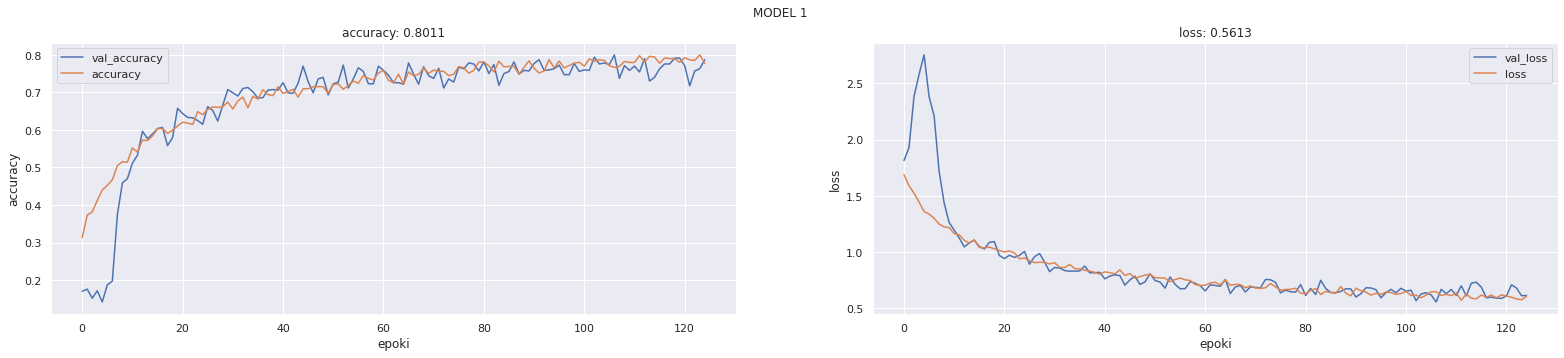

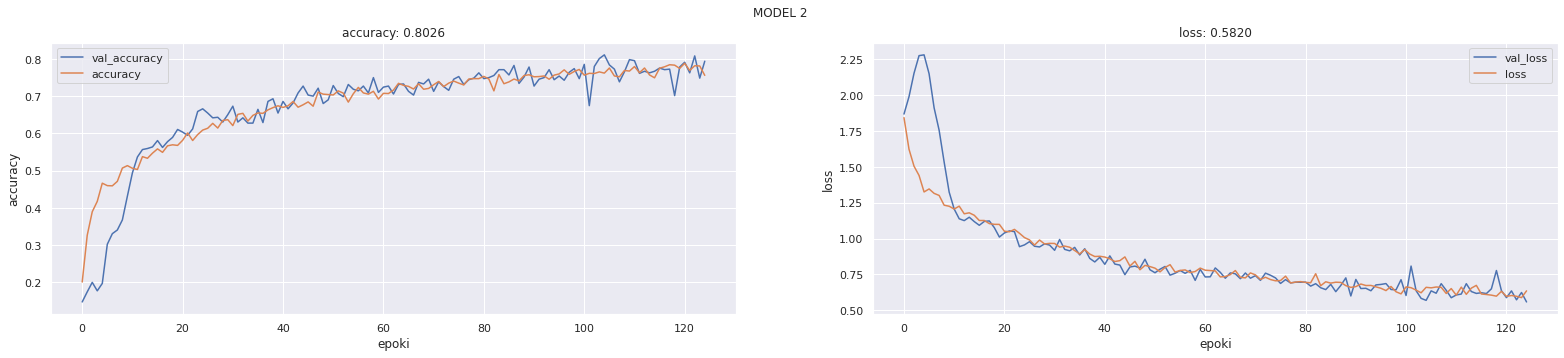

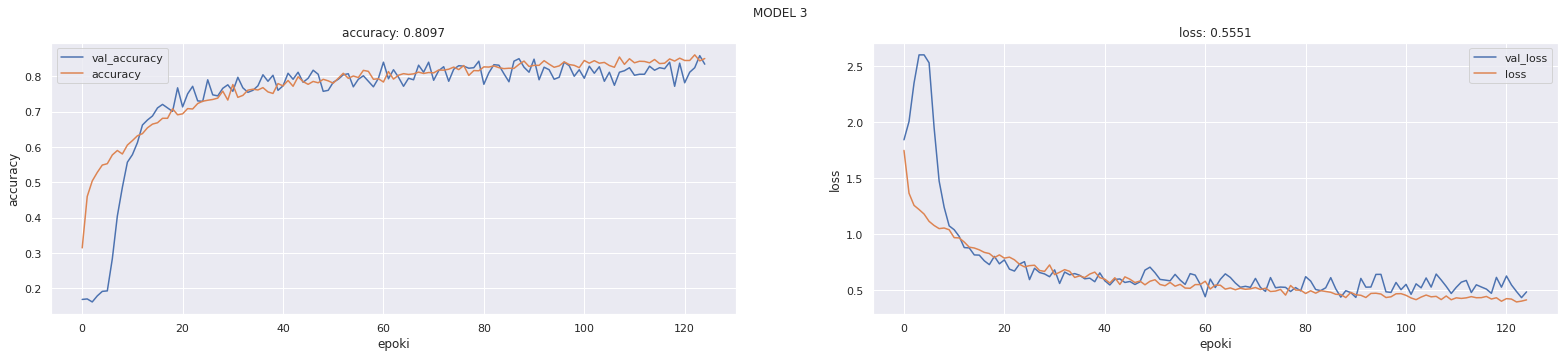

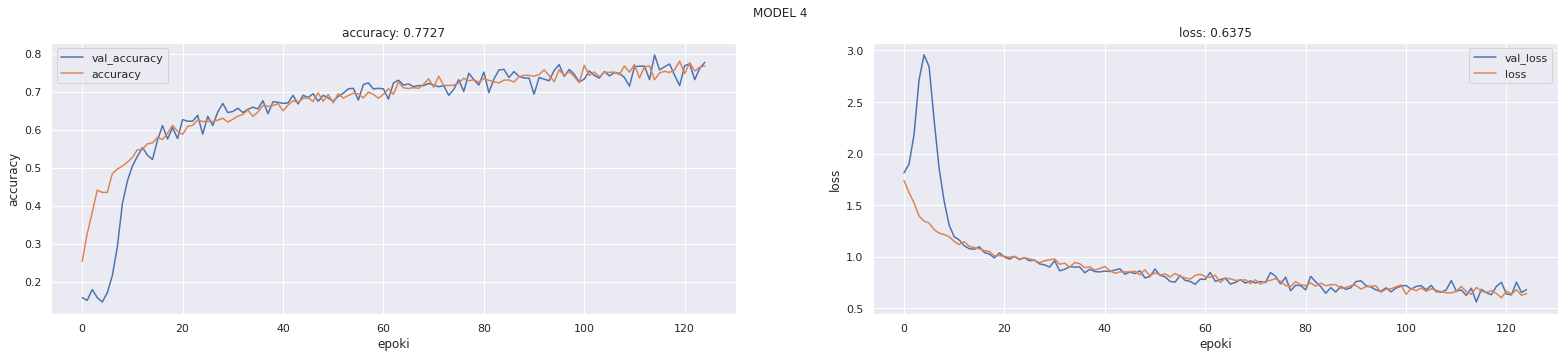

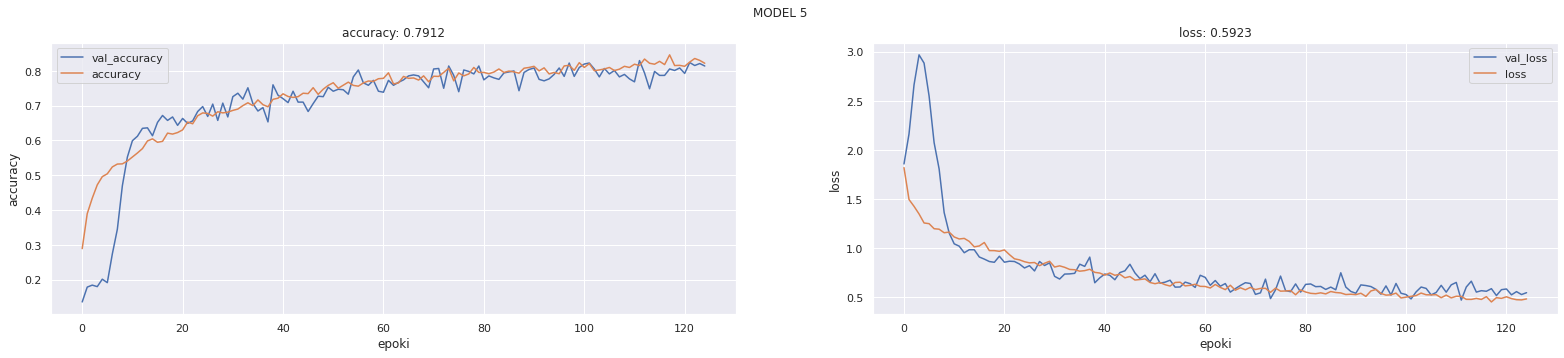

In [29]:
modelObj_1.plot_hist(title='MODEL 1')
modelObj_2.plot_hist(title='MODEL 2')
modelObj_3.plot_hist(title='MODEL 3')
modelObj_4.plot_hist(title='MODEL 4')
modelObj_5.plot_hist(title='MODEL 5')

In [ ]:
# %tensorboard --logdir logs

## <a name='19'></a>3.6. Testowanie modeli

In [30]:
best_model = load_model('/content/drive/My Drive/ColabNotebooks/intel_image/models/2020-06-05/model_3_L0.36_A0.86.h5') 

# best_model.summary()

In [31]:
class TestModel:

  def __init__(self, model_dict):
    self.model_dict          = model_dict
    self.y_pred_list         = []
    self.models_metrics_list = []
    self.models_errors_list  = []
    self.model_name_idx      = 0
    self.y_pred_idx          = 0
    self.models_metrics_idx  = 0
    self.errors_df_idx       = 0
    self.test_dir_list       = [test_buildings_dir, test_forest_dir, test_glacier_dir, test_mountain_dir, test_sea_dir, test_street_dir]
    

  def __prepare_test_generator(self):
    self.test_datagen = ImageDataGenerator(rescale=1./255.)
    self.test_generator    = self.test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='categorical', shuffle=False )


  def __get_y_pred(self):
    self.__prepare_test_generator()
    for i, name in enumerate(self.model_dict):
      self.model    = [val for val in self.model_dict.values() ][i]
      self.y_proba  = self.model.predict(self.test_generator , steps=len(self.test_generator ), batch_size=32 ) 
      self.y_pred   = np.argmax(self.y_proba, axis=1)
      self.y_pred_list.append( self.y_pred )
    

  def __get_model_metrics(self):
    for i, name in enumerate(self.model_dict):
      self.model          = [val for val in self.model_dict.values() ][i]
      self.models_metrics = self.model.evaluate(self.test_generator , steps=len(self.test_generator ), batch_size=32, verbose=0)
      self.models_metrics_list.append(self.models_metrics)


  def __create_errors_data_frame(self):
    self.errors_df           = pd.DataFrame( index= self.test_generator.filenames )
    self.y_true              = self.test_generator.classes
    for i, y_pred in enumerate(self.y_pred_list):
      self.errors_df['y_true']             = self.y_true
      self.errors_df['y_pred_' + str(i) ]   = y_pred
      self.errors_df['incorrect_' + str(i)] =  (self.y_true != y_pred) * 1 

      self.number_of_errors = len(self.errors_df[self.errors_df['incorrect_'+ str(i)] == 1].index)
      self.models_errors_list.append(self.number_of_errors)


  def create_matrix(self):
    self.__get_y_pred()
    self.__get_model_metrics()
    self.__create_errors_data_frame()

    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(30, 8))
    fig.subplots_adjust(hspace=0.7, wspace=0.2)

    for i in range(1, 7):
      fig.add_subplot(2, 3, i) 

      self.cm = confusion_matrix(self.y_true, self.y_pred_list[self.y_pred_idx])
  

      g = sns.heatmap(self.cm, annot=True, fmt='d', linewidth=.2, cmap='Blues',
                      xticklabels=self.test_generator.class_indices.keys(), yticklabels=self.test_generator.class_indices.keys(),
                      annot_kws={"size": 15})

      g.tick_params(labelsize=15)
      g.xaxis.tick_top()
      plt.yticks(rotation=0) 
      plt.xticks(rotation=0) 

      plt.title(f'{ list(model_dict.keys())[self.model_name_idx]}\n Accuracy: {self.models_metrics_list[self.models_metrics_idx][1]:.4f} Loss: {self.models_metrics_list[self.models_metrics_idx][0]:.4f}\n Liczba pomyłek: {self.models_errors_list[self.errors_df_idx]}',
                    fontdict={'fontsize' : 15, 'weight':'bold'})

      self.model_name_idx     += 1
      self.y_pred_idx         += 1
      self.models_metrics_idx += 1
      self.errors_df_idx      += 1
    plt.show()  


  def __set_column_name_prefix(self, model_name):
    for i, name in enumerate(self.model_dict):
      if str(i) in model_name:
        self.incorrect_col_name = 'incorrect_'
        self.y_pred_col_name = 'y_pred_'
        self.incorrect_col_name = self.incorrect_col_name + str(i)
        self.y_pred_col_name = self.y_pred_col_name + str(i)
      elif 'Best' in model_name:
        self.incorrect_col_name = 'incorrect_'
        self.y_pred_col_name = 'y_pred_'
        self.incorrect_col_name = self.incorrect_col_name + str(5)
        self.y_pred_col_name = self.y_pred_col_name + str(5)    


  def __get_image_name_and_category_from_df(self, col_idx):
    self.img = [ img.split('/')[1] for i, img in enumerate(self.errors_df[self.errors_df[self.incorrect_col_name] == 1].index) ][col_idx]
    self.category = [ img.split('/')[0] for i, img in enumerate(self.errors_df[self.errors_df[self.incorrect_col_name] == 1].index) ][col_idx]


  def __get_true_and_pred_label_from_df(self, col_idx):
    self.pred_label = [self.pred_label for i, self.pred_label in enumerate(self.errors_df[self.errors_df[self.incorrect_col_name] == 1][self.y_pred_col_name].values) ][col_idx]
    self.true_label = [self.true_label for i, self.true_label in enumerate(self.errors_df[self.errors_df[self.incorrect_col_name] == 1]['y_true'].values) ][col_idx]

  
  def __concatenate_class_inidces_with_label_from_df(self):
      for key, val in self.test_generator.class_indices.items():
        if val == self.pred_label:
          self.pred_label = key
        if val == self.true_label:
          self.true_label = key 
          

  def __prepare_image_path(self): 
      self.dir_name = test_dir + '/'+ self.category
      self.img_path = os.path.join(self.dir_name, self.img)       


  def show_incorrect_images(self, model_name, amount=10):
    self.__set_column_name_prefix(model_name)

    rows= 5
    cols= 8
    col_idx = 0
  
    fig = plt.figure(figsize=(30, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0)

    for i in range(1, amount):
      fig.add_subplot(rows, cols, i)
      self.__get_image_name_and_category_from_df(col_idx)
      self.__get_true_and_pred_label_from_df(col_idx)
      self.__concatenate_class_inidces_with_label_from_df()
      self.__prepare_image_path()

      self.img = image.load_img(self.img_path)
      plt.imshow(self.img)
      plt.title(f'true label: {self.true_label}\n predicted: {self.pred_label}', fontdict = {'color' : 'green', 'weight' : 'bold', 'size' : 12}) 
      plt.axis('off')
      col_idx += 1
    plt.show()    

In [32]:
model_dict = {
              'model 1'    : model_1,
              'model 2'    : model_2,
              'model 3'    : model_3,
              'model 4'    : model_4,
              'model 5'    : model_5,
              'Best model' : best_model              
             }


TestModel_obj = TestModel( model_dict= model_dict)

Found 318 images belonging to 6 classes.


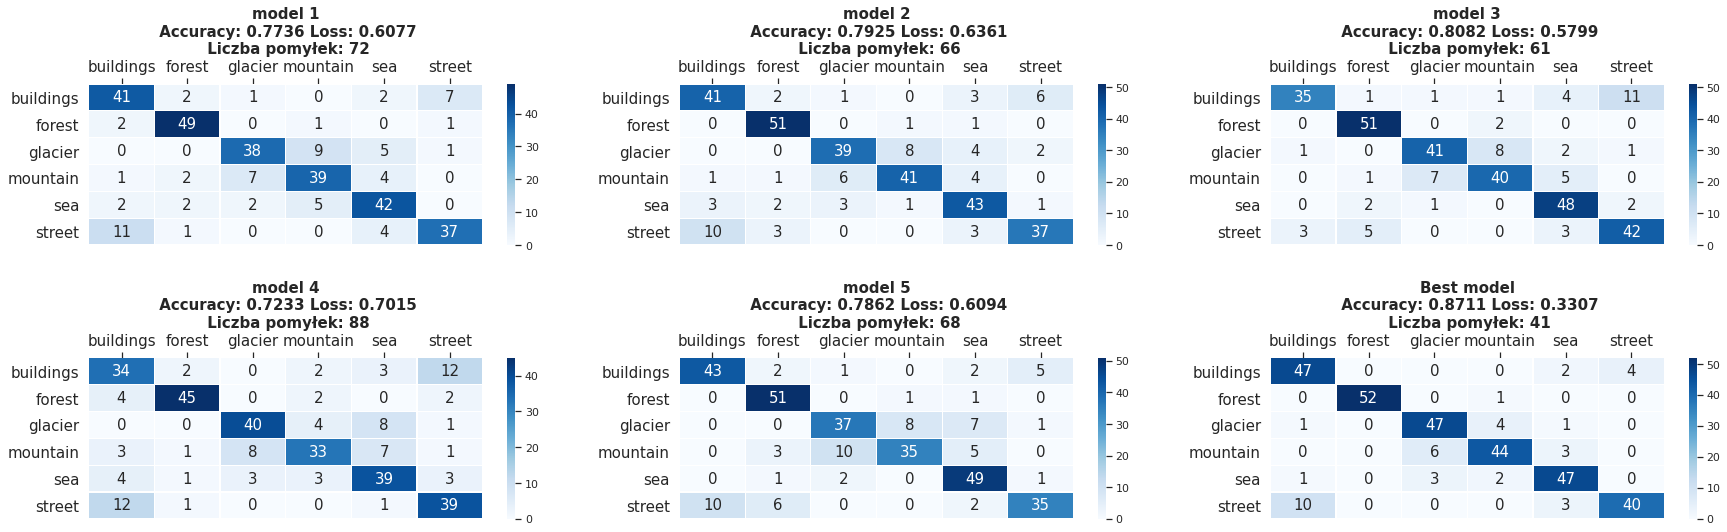

In [33]:
TestModel_obj.create_matrix() 

### <a name='20'></a>3.6.1 Najlepsze modele

Found 318 images belonging to 6 classes.


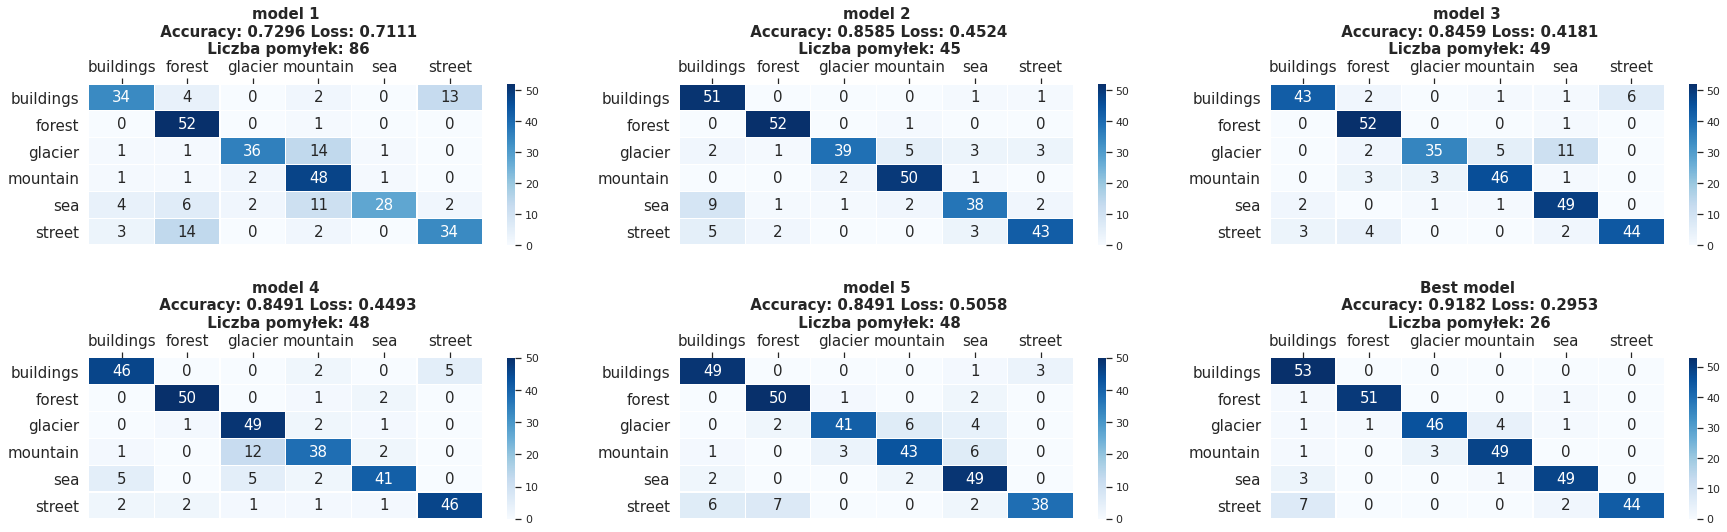

In [ ]:
TestModel_obj.create_matrix() 

### <a name='21'></a>3.6.2 Wyświetlenie błędnie sklasyfikowanych zdjęć

In [ ]:
TestModel_obj.show_incorrect_images(model_name='model 5', amount= 25)

In [ ]:
TestModel_obj.show_incorrect_images(model_name='Best model', amount= 25)

# <a name='22'></a> **4. Testowanie PyTorch'a**

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.nn import functional as F
import torch.optim as optim



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')


torch.set_printoptions(linewidth=120)
print()
print('torch: ',torch.__version__)
print('torchvision: ',torchvision.__version__)

Working on device=cuda

torch:  1.5.0+cu101
torchvision:  0.6.0+cu101


In [ ]:
training_ransform = transforms.Compose(
                                        [
                                        transforms.Resize ( (150 ,150)), # resize each image to a 150x150
                                        transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                                              [0.5, 0.5, 0.5],
                                                              [0.5, 0.5, 0.5]
                                                             )
                                        ]
                                       )

validation_transform = transforms.Compose(
                                           [
                                          transforms.Resize ( (150 ,150)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                                                [0.5, 0.5, 0.5],
                                                                [0.5, 0.5, 0.5]
                                                              )
                                          ]
                                         )

testing_transform = transforms.Compose(
                                        [
                                        transforms.Resize ( (150 ,150)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                                              [0.5, 0.5, 0.5],
                                                              [0.5, 0.5, 0.5]
                                                             )
                                        ]
                                       )


trainset = datasets.ImageFolder(root= train_dir, transform= training_ransform )
validnset = datasets.ImageFolder(root= valid_dir, transform= validation_transform )
testset = datasets.ImageFolder(root= test_dir, transform= testing_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
sample = next(iter(trainset))

len(sample)

2

In [ ]:
image, label = sample

In [ ]:
image.shape

torch.Size([3, 150, 150])

In [ ]:
label

0

In [ ]:
batch = next(iter(train_loader))

images, labels = batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([0, 2, 3, 4, 5, 3, 2, 1, 3, 0, 3, 3, 1, 4, 0, 1, 0, 3, 4, 4, 3, 4, 3, 1, 2, 3, 1, 3, 0, 2, 0, 0])


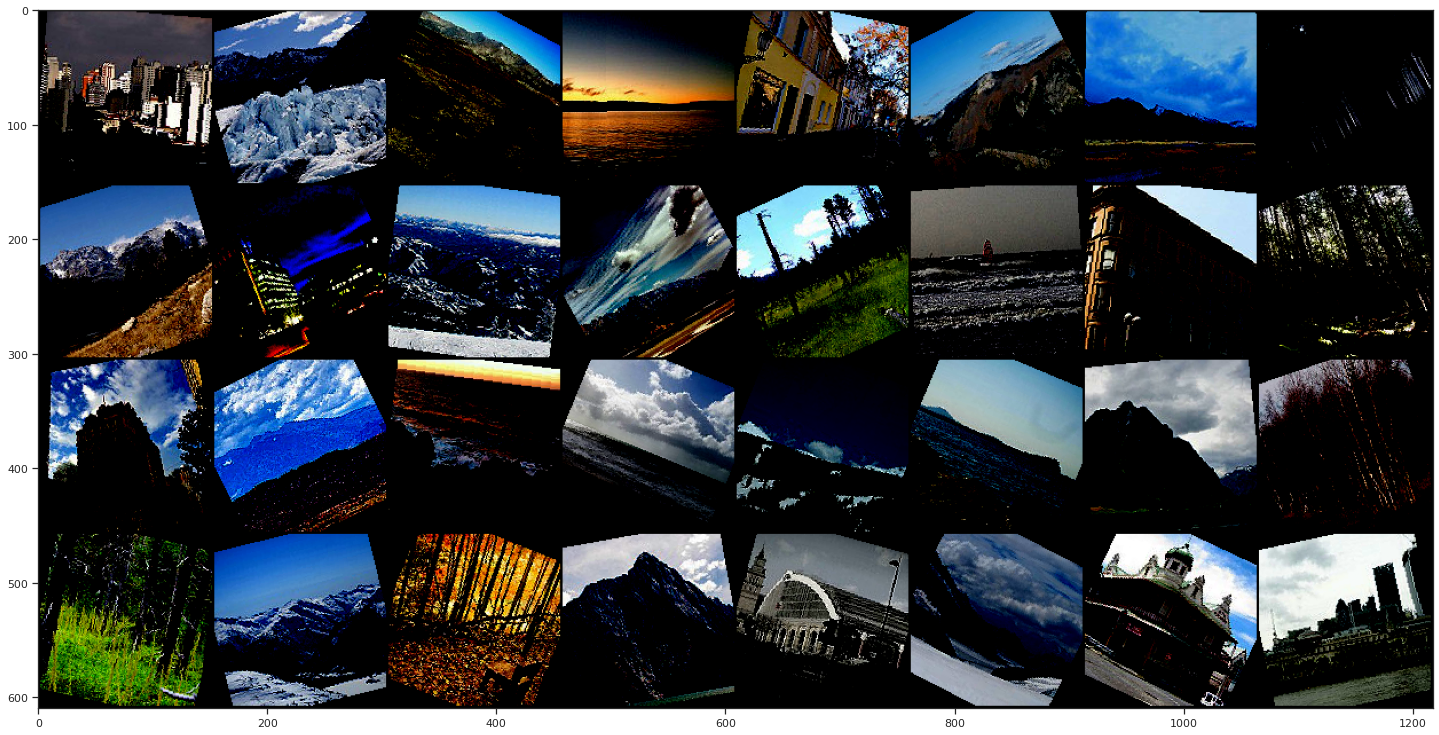

In [ ]:
grid = torchvision.utils.make_grid(images, nrow= 8)

plt.figure(figsize=(25, 25))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels:', labels)

In [ ]:
trainset.class_to_idx

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1)
               
        self.fc1 = nn.Linear(in_features=96*4*4, out_features=120) 
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=6)
    
    def forward(self, input):
        x = self.conv1(input)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) 

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) 

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) 

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2) 

        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.shape)
        x = x.reshape(-1, 96*4*4) # 4 * 4 is height and width of each of the 12 output channels
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        # output layer
        x = self.out(x)
        # x = F.softmax(x, dim=1)
        
        return x

In [ ]:
model = CNN()
model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=7776, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=6, bias=True)
)


In [ ]:
batch = next(iter(train_loader))

images, labels = batch
images, labels = images.to(device), labels.to(device)

model.forward(images)

In [ ]:
sample = next(iter(trainset))
image, label = sample
image.shape # (batch_size, in_channels, height, width)

torch.Size([3, 150, 150])

In [ ]:
model.conv1.weight.shape

torch.Size([6, 3, 5, 5])

In [ ]:
model.conv2.weight.shape

torch.Size([12, 6, 3, 3])

In [ ]:
model.conv2.weight[0].shape

torch.Size([6, 3, 3])

In [ ]:
model.fc1.weight.shape

torch.Size([120, 1536])

In [ ]:
model.fc2.weight.shape

torch.Size([60, 120])

In [ ]:
model.out.weight.shape

torch.Size([6, 60])

In [ ]:
batch = next(iter(train_loader))

images, labels = batch
images, labels = images.to(device), labels.to(device)

# Calucalating the Loss

In [ ]:
preds = model(images)
loss = F.cross_entropy(preds, labels)
loss.item()

torch.Size([32, 96, 4, 4])


1.8176839351654053

# Calculating the Gradients

In [ ]:
print(model.conv1.weight.grad)

None


In [ ]:
loss.backward()  # Calculating the gradients

In [ ]:
model.conv1.weight.grad.shape

torch.Size([6, 3, 5, 5])

# Updating the Weights

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
loss.item()

1.8176839351654053

In [ ]:
def get_number_true_predictions(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

get_number_true_predictions(preds, labels) # number of correct predicitons - 5% chance to be correct

1

In [ ]:
optimizer.step() # Updating the weights

In [ ]:
preds = model(images)
loss = F.cross_entropy(preds, labels)
loss.item()

torch.Size([32, 96, 4, 4])


1.7124481201171875

In [ ]:
get_number_true_predictions(preds, labels)

13

# Training with a single batch

In [ ]:
model = CNN()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)

batch = next(iter(train_loader))      # get batch
images, labels = batch

preds = model(images)                 # pass batch
loss = F.cross_entropy(preds, labels) # calculate loss

loss.backward()                       # Calculate gradients
optimizer.step()                      # Updating weights

# --------------------------------------

print('Loss 1: ', loss.item())

preds = model(images)
loss = F.cross_entropy(preds, labels)

print('Loss 2: ', loss.item())

torch.Size([32, 96, 4, 4])
Loss 1:  1.8040696382522583
torch.Size([32, 96, 4, 4])
Loss 2:  1.7612425088882446


# Training with all batch - one epoch

In [ ]:
model = CNN()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# we're gonna track the loss and number of correct predictions
total_loss = 0
total_correct = 0

for batch in train_loader:                # get batch
    images, labels = batch

    preds = model(images)                 # pass batch
    loss = F.cross_entropy(preds, labels) # calculate loss

    optimizer.zero_grad()                 # zero out the gradients
    loss.backward()                       # Calculate gradients
    optimizer.step()                      # Updating weights

    total_loss += loss.item()
    total_correct += get_number_true_predictions(preds, labels)


print('epoch: ', 0, 'total correct of predictions: ',  total_correct, 'loss: ', total_loss)

In [ ]:
total_correct / len(trainset) # accuracy

0.454981884057971

# Training with multiple epochs

In [ ]:
model = CNN()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.01)


for epoch in range(10):

    # we're gonna track the loss and number of correct predictions
    total_loss = 0
    total_correct = 0

    for batch in train_loader:                # get batch
        images, labels = batch

        preds = model(images)                 # pass batch
        loss = F.cross_entropy(preds, labels) # calculate loss

        optimizer.zero_grad()                 # zero out the gradients
        loss.backward()                       # Calculate gradients
        optimizer.step()                      # Updating weights

        total_loss += loss.item()
        total_correct += get_number_true_predictions(preds, labels)


    print('epoch: ',epoch, 'total correct of predictions: ',total_correct, 'loss: ',total_loss)

epoch:  0 total correct of predictions:  4751 loss:  474.43833112716675
epoch:  1 total correct of predictions:  6268 loss:  372.4463058114052
epoch:  2 total correct of predictions:  6436 loss:  357.33858889341354
epoch:  3 total correct of predictions:  6639 loss:  341.7836201786995
epoch:  4 total correct of predictions:  6705 loss:  345.0844560265541
epoch:  5 total correct of predictions:  6620 loss:  346.36316365003586
epoch:  6 total correct of predictions:  6898 loss:  334.22465467453003
epoch:  7 total correct of predictions:  6848 loss:  334.2881732583046
epoch:  8 total correct of predictions:  6903 loss:  329.58729687333107
epoch:  9 total correct of predictions:  6921 loss:  336.4905214905739


In [ ]:
total_correct / len(trainset) # accuracy

0.6269021739130435